# Análise dos Resultados obtidos durante as iterações do modelo

# Setup
## Utils

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys

sys.path.append("..")

import pandas as pd

import numpy as np
from skimage.color import lab2rgb, label2rgb

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

from tqdm import tqdm

from generate_distance_map import generate_distance_map

# load label
from skimage.measure import label, regionprops, regionprops_table

from src.utils import read_tiff, read_yaml, fix_relative_paths


# from evaluation import evaluate_iteration
from pred2raster import pred2raster
from sample_selection import get_components_stats

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns

import os
from os.path import dirname, join
import gc

from collections.abc import Iterable

from joblib import Parallel, delayed

In [22]:
def autolabel(ax: np.ndarray, format: str = None):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    """
    if not isinstance(ax, Iterable):
        ax = [ax]

    if format is None:
        format = "{:.0f}"

    for ax_ in ax:
        for rect in ax_.patches:
            height = rect.get_height()
            ax_.annotate(
                format.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

In [23]:
sns.set_style("darkgrid")
# set figsize
plt.rcParams["figure.figsize"] = (8, 5)

In [24]:
# increase DPI
plt.rcParams["figure.dpi"] = 120

In [51]:
# dict_colors =
# generate color palette to values from 1 to 14
dict_colors = {}

dict_colors["tree_type"] = {
    key: color for key, color in zip(range(1, 18), sns.color_palette("tab20", 18))
}

# Outpth path to load the data

In [42]:
DATA_FOLDER_NAME = dirname(os.getcwd())

In [43]:
VERSION_NAME = "2.5_version_data"
DATA_PATH = join(DATA_FOLDER_NAME, VERSION_NAME)

# Data loading

In [44]:

iter_folders = os.listdir(DATA_PATH)

iter_folders = [folder for folder in iter_folders if folder.startswith("iter_")]

iter_folders.sort()

iter_folders.pop()

'iter_009'

In [45]:
def get_iter_stats(iter_folder, labels_file="all_labels_set.tif"):
    num_iter = int(iter_folder.split("_")[1])
    if num_iter != 0:
        label_path = os.path.join(
            DATA_PATH, iter_folder, "new_labels", labels_file
        )
    else:
        label_path = args.train_segmentation_path

    label_img = read_tiff(label_path)

    components = label(label_image = label_img)

    components_stats = get_components_stats(components, label_img)
    components_stats.reset_index(inplace=True)

    iter_num = int(iter_folder.split("_")[1])

    components_stats["iter"] = f"iter_{iter_num:03d}"

    components_stats["iter_num"] = iter_num

    return components_stats

In [46]:
all_iter_stats = Parallel(n_jobs=-1)(
    delayed(get_iter_stats)(iter_folder, "all_labels_set.tif")
    for iter_folder in iter_folders
)
all_labels_stats = pd.concat(all_iter_stats)

/home/dariossh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/dariossh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/dariossh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As

In [47]:
selected_iter_stats = Parallel(n_jobs=-1)(
    delayed(get_iter_stats)(iter_folder, "selected_labels_set.tif")
    for iter_folder in iter_folders
)
selected_labels_stats = pd.concat(selected_iter_stats)

In [48]:
label_img = read_tiff(os.path.join(DATA_PATH, args.train_segmentation_path))

total_area = label_img.shape[0] * label_img.shape[1]

print("Quantidade de pixels na imagem:")
print(f"{total_area:,.0f}")

Quantidade de pixels na imagem:
522,876,822


# Análise da área coberta pela segmentação semântica

In [49]:
last_iter_num = all_labels_stats["iter_num"].max()

last_iter_stats = all_labels_stats[
    all_labels_stats["iter_num"] == all_labels_stats["iter_num"].max()
]

print(
    f"Área coberta pela segmentação semântica, considerando a imagem { label_img.shape}: {last_iter_stats['area'].sum()/total_area:,.2%} da imagem"
)

Área coberta pela segmentação semântica, considerando a imagem (22867, 22866): 18.72% da imagem


## Distribuição da área coberta por cada tipo de árvore

Análise considerando valores absolutos:

In [57]:
last_iter_stats.groupby("tree_type")["area"].sum().sort_values(ascending=False)

tree_type
4     14323569.0
1     12847874.0
5     11220640.0
12     9020693.0
15     8751516.0
8      7721627.0
16     6205852.0
17     6166868.0
14     4858676.0
9      4643813.0
10     4088604.0
7      3399058.0
3      2101638.0
6      2090650.0
13      246769.0
2       111709.0
11       99233.0
Name: area, dtype: float64

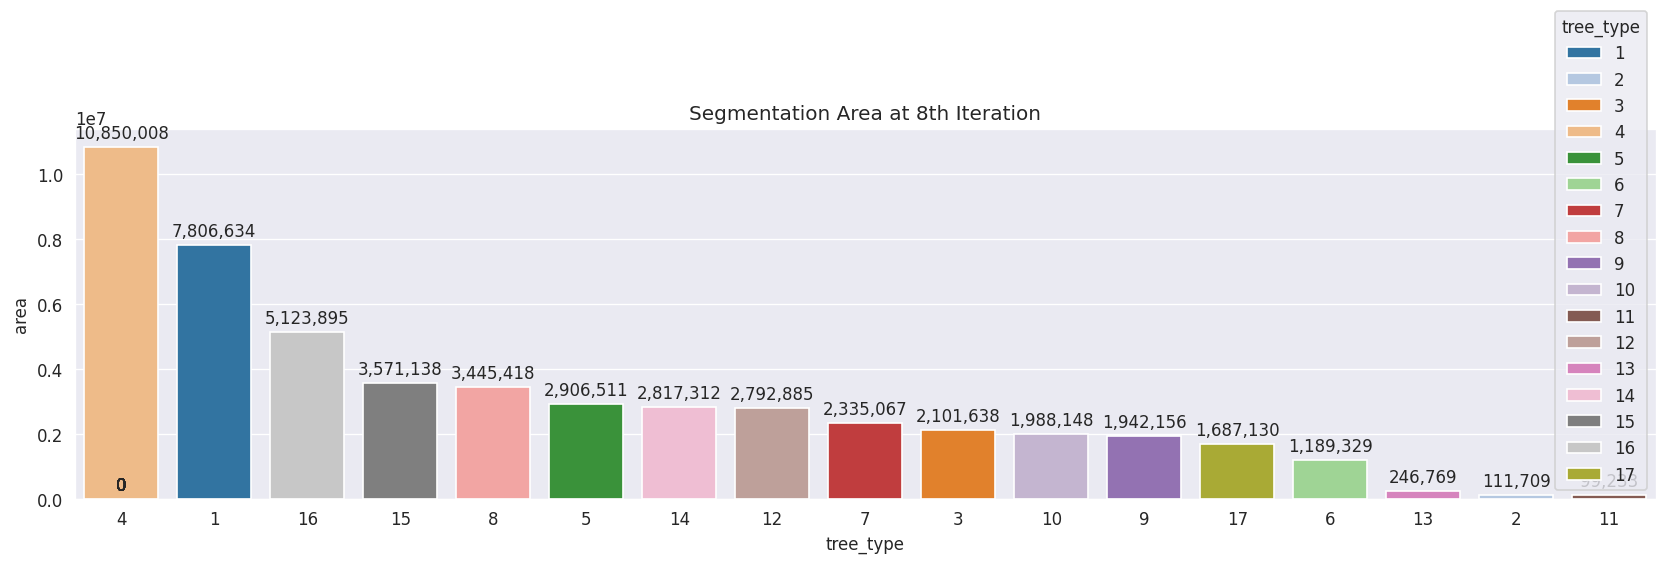

In [64]:
# change fig size
fig = plt.gcf()
fig.set_size_inches(17, 4)

ax = sns.barplot(
    data=selected_labels_stats[selected_labels_stats["iter_num"] == selected_labels_stats["iter_num"].max()],
    x="tree_type",
    y="area",
    estimator=lambda group: group.sum(),
    errorbar=None,
    order=selected_labels_stats[selected_labels_stats["iter_num"] == selected_labels_stats["iter_num"].max()].groupby("tree_type")["area"]
        .sum()
        .sort_values(ascending=False)
        .index,
    palette=dict_colors["tree_type"],
    hue="tree_type"
)


ax.set_title(f"Segmentation Area at {selected_labels_stats['iter_num'].max()}th Iteration")

autolabel(ax, "{:,.0f}")

plt.show()

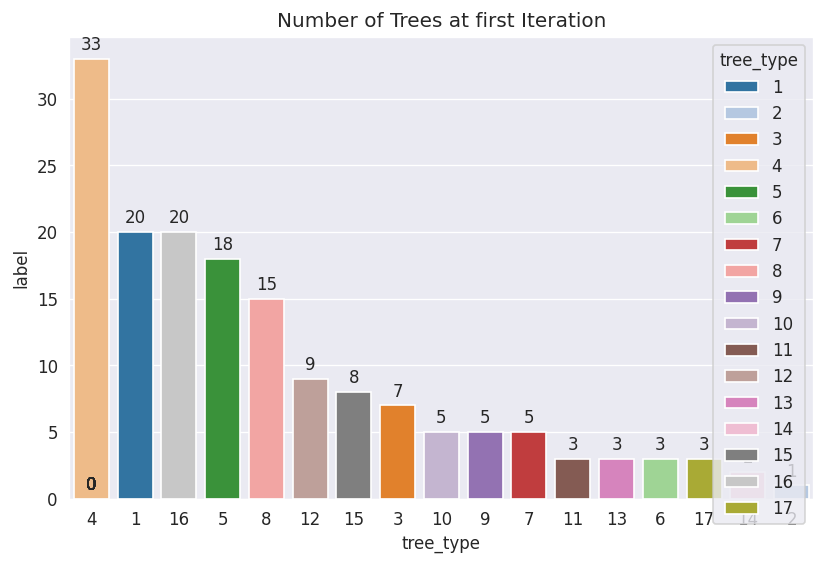

In [66]:
ax = sns.barplot(
    data=selected_labels_stats[selected_labels_stats["iter_num"] == 0],
    x="tree_type",
    y="label",
    estimator=lambda group: group.nunique(),
    errorbar=None,
    order=selected_labels_stats[selected_labels_stats["iter_num"] == 0]
            .groupby("tree_type")["label"]
            .nunique()
            .sort_values(ascending=False)
            .index,
    palette=dict_colors["tree_type"],
    hue = "tree_type"
)

ax.set_title(f"Number of Trees at first Iteration")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}".format(y)))

autolabel(ax, "{:.0f}")

plt.show()

Agora, em valores relativos ao total da área segmentada:

## Evolução Temporal da área segmentada

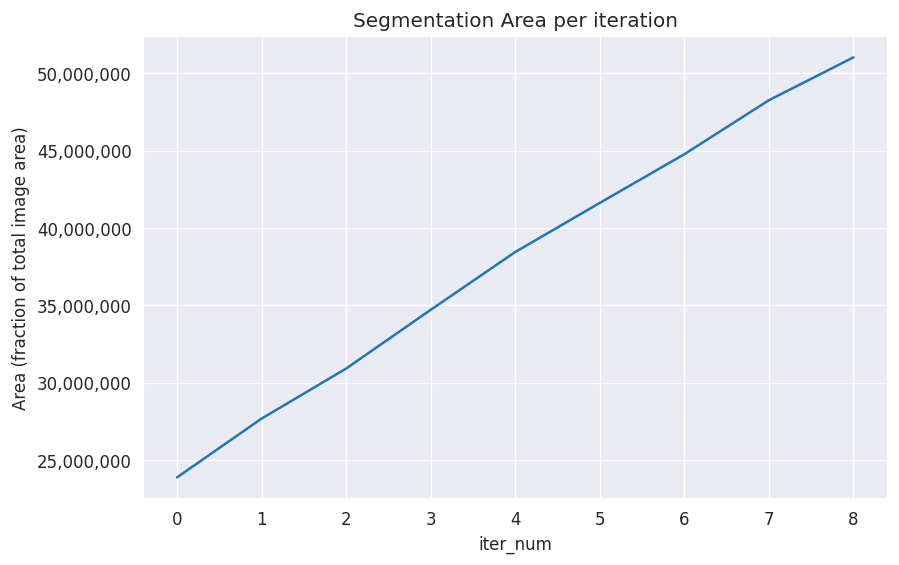

In [67]:
ax = sns.lineplot(
    data=selected_labels_stats,
    x="iter_num",
    y="area",
    estimator=lambda x: x.sum(),
    errorbar=None,
)

ax.set_title("Segmentation Area per iteration")
ax.set_ylabel("Area (fraction of total image area)")

# format y ticks labels with FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:,.0f}".format(y)))

plt.show()

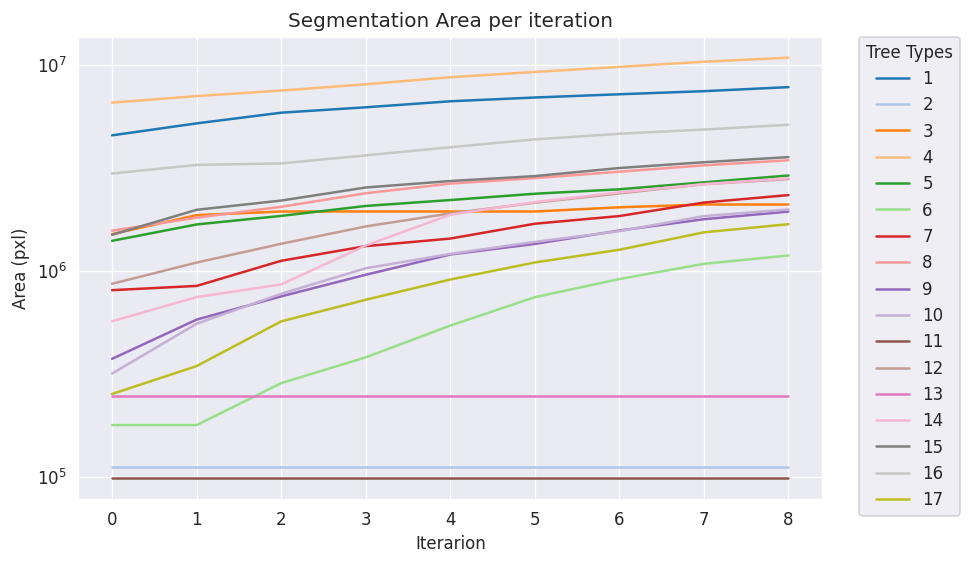

In [68]:
ax = sns.lineplot(
    data=selected_labels_stats,
    x="iter_num",
    y="area",
    hue="tree_type",
    estimator="sum",
    errorbar=None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Segmentation Area per iteration")

# set y log scale
ax.set_yscale("log")

ax.set_ylabel("Area (pxl)")
ax.set_xlabel("Iterarion")

# set outside box legend
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title="Tree Types")

plt.show()

In [69]:
print("Número total de árvores identificadas:")
print(last_iter_stats["label"].nunique())

Número total de árvores identificadas:
2070


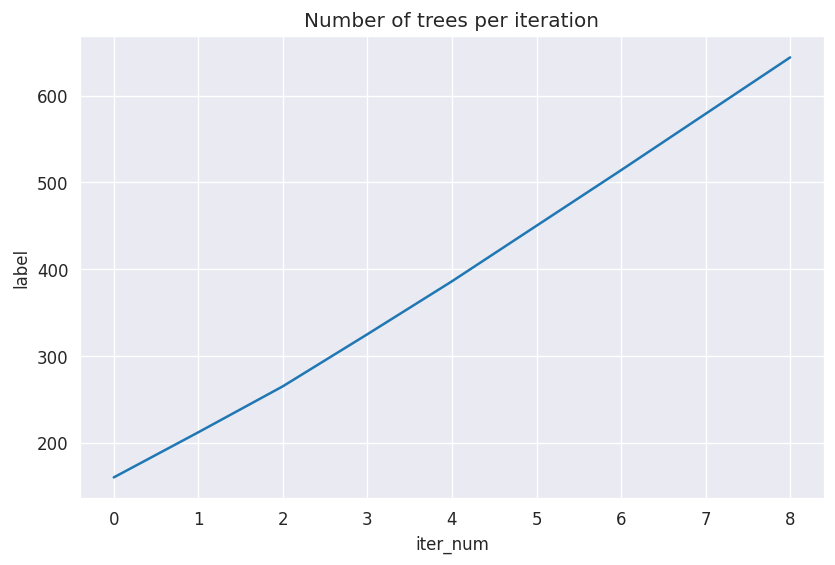

In [70]:
ax = sns.lineplot(
    data=selected_labels_stats, x="iter_num", y="label", estimator="nunique", errorbar=None
)

ax.set_title("Number of trees per iteration")

autolabel(ax, "{:.0f}")

plt.show()

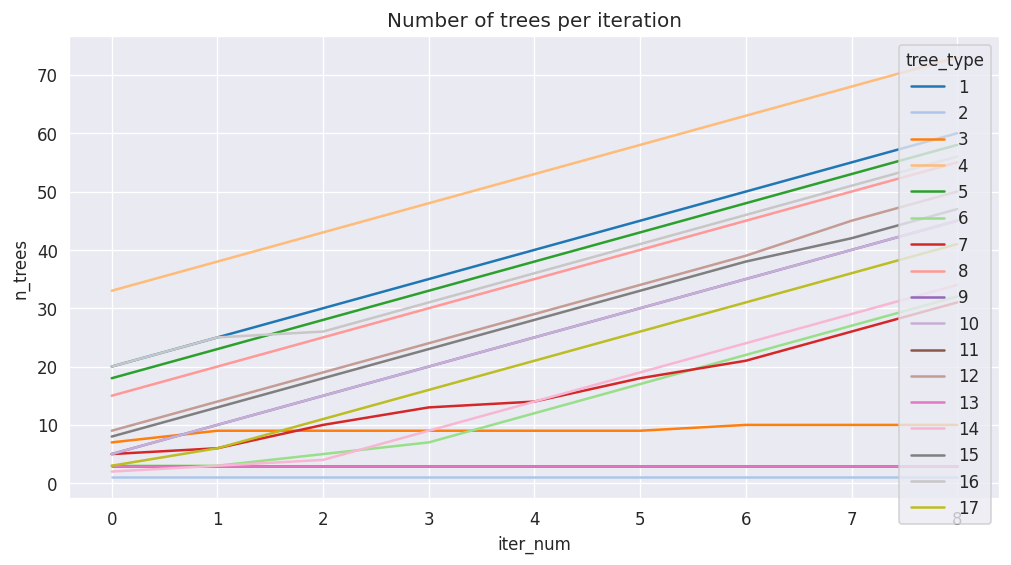

In [71]:
count_by_iter = selected_labels_stats.groupby(
    ["tree_type", "iter_num"], as_index=False, sort=True
)["label"].nunique()
count_by_iter.rename(columns={"label": "n_trees"}, inplace=True)

# change size fig
fig = plt.gcf()
fig.set_size_inches(10, 5)

ax = sns.lineplot(
    data=count_by_iter,
    x="iter_num",
    y="n_trees",
    hue="tree_type",
    errorbar=None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Number of trees per iteration")

plt.show()

A versão com a antiga loss implementada pela Laura teve a evolução de 4 espécies de árvores.

Enquanto que essa, teve a evolução de apena 3 espécies.

# Analisando evolução do banco de imagens

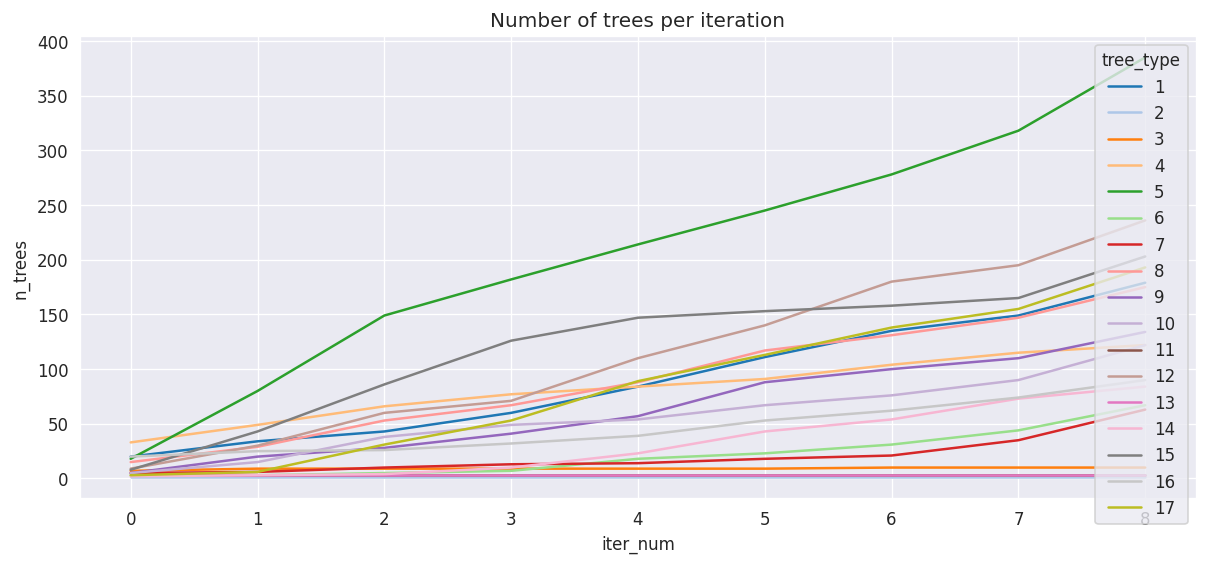

In [79]:
count_by_iter = all_labels_stats.groupby(
    ["tree_type", "iter_num"], as_index=False, sort=True
)["label"].nunique()
count_by_iter.rename(columns={"label": "n_trees"}, inplace=True)

# change size fig
fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = sns.lineplot(
    data=count_by_iter,
    x="iter_num",
    y="n_trees",
    hue="tree_type",
    errorbar = None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Number of trees per iteration")

plt.show()

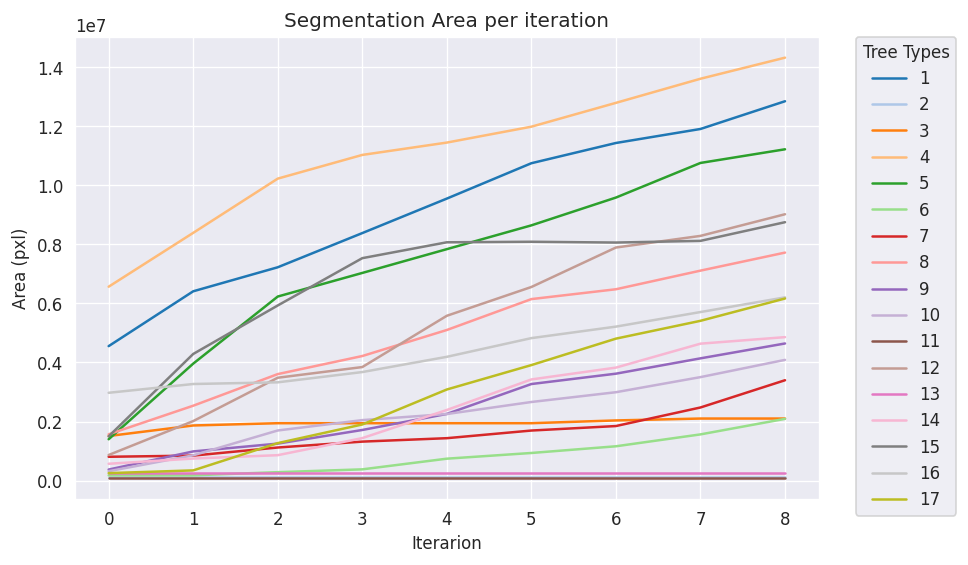

In [73]:
ax = sns.lineplot(
    data=all_labels_stats,
    x="iter_num",
    y="area",
    hue="tree_type",
    estimator="sum",
    errorbar=None,
    palette=dict_colors["tree_type"],
)

ax.set_title("Segmentation Area per iteration")

# set y log scale
# ax.set_yscale("log")

ax.set_ylabel("Area (pxl)")
ax.set_xlabel("Iterarion")

# set outside box legend
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title="Tree Types")

plt.show()

# Evolução da Acurácia

In [74]:
metrics_evo = []

for iter in iter_folders[1:]:
    accu = read_yaml(os.path.join(DATA_PATH, iter, "test_metrics.yaml"))
    
    metrics_evo.append(accu)
    
metrics_evo = pd.DataFrame(metrics_evo)

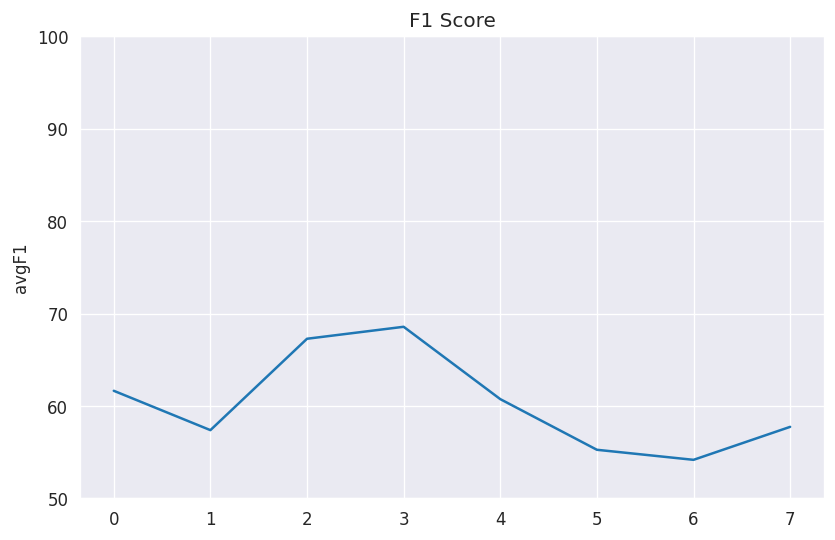

In [86]:
ax = sns.lineplot(metrics_evo["avgF1"])
ax.set_ylim(50, 100)
ax.set_title("F1 Score")
plt.show()

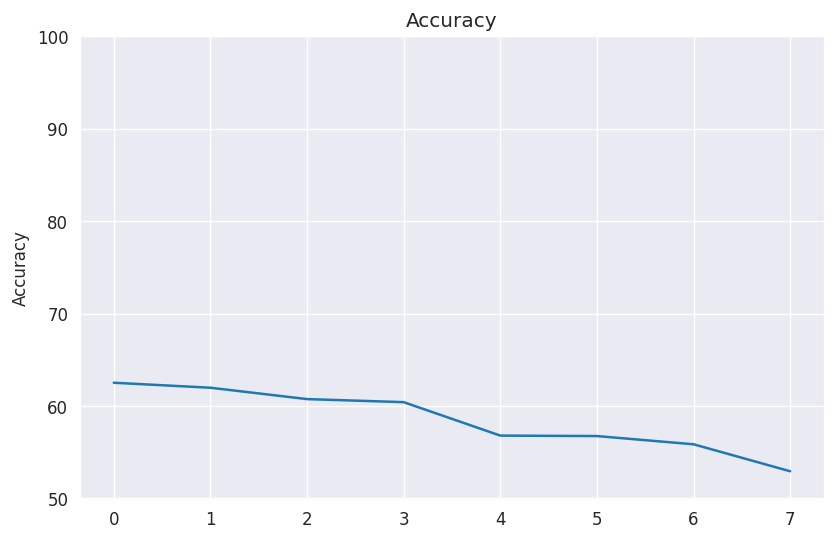

In [87]:
ax = sns.lineplot(metrics_evo["Accuracy"])
ax.set_ylim(50, 100)
ax.set_title("Accuracy")
plt.show()

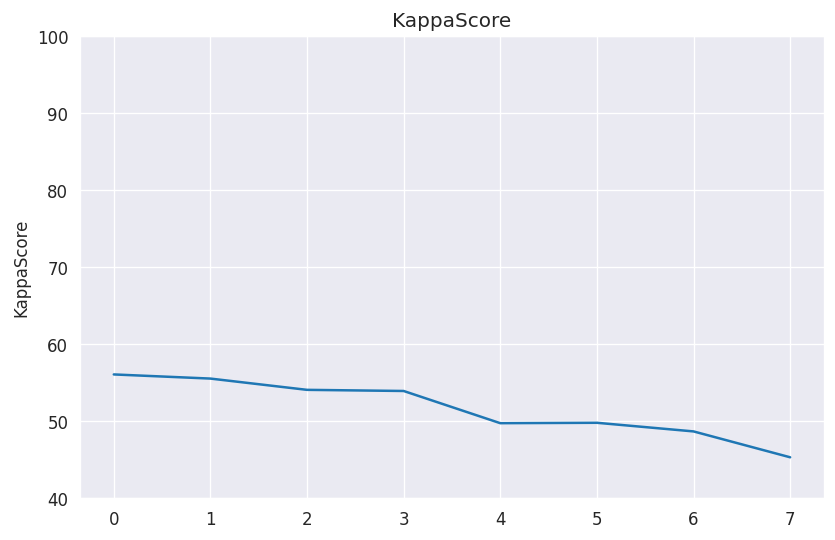

In [89]:
ax = sns.lineplot(metrics_evo["KappaScore"])
ax.set_ylim(40, 100)
ax.set_title("KappaScore")
plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,64.730656,100.000000,44.393276,94.811111,70.814482,0.993206,9.779043,54.690095,57.803886,23.012260,100.000000,9.926344,100.000000,100.000000,46.505903,70.413713,100.000000
1,57.630601,0.000000,61.454616,94.205324,80.337091,0.928374,17.089697,53.838006,53.551688,14.715460,100.000000,18.740692,100.000000,100.000000,55.114180,67.856642,100.000000
2,57.097466,100.000000,73.493946,93.963127,71.387472,100.000000,9.945798,50.589301,45.084549,0.031944,100.000000,10.319256,100.000000,100.000000,57.895581,73.788494,100.000000
3,56.073308,100.000000,66.641660,92.646504,65.765093,100.000000,20.750218,56.225822,53.184772,9.912426,100.000000,24.250096,100.000000,100.000000,51.349318,68.822922,100.000000
4,53.455526,0.000000,61.674096,90.616429,68.563928,100.000000,19.227177,35.072017,43.935335,5.371513,100.000000,17.970118,100.000000,100.000000,67.270076,69.374791,100.000000
5,51.938364,0.000000,54.550229,88.352908,69.383340,100.000000,11.906019,44.659914,46.562250,10.267764,100.000000,18.122173,100.000000,0.136972,77.993493,65.458596,100.000000
6,55.238436,0.000000,52.604799,88.832027,73.267722,100.000000,7.026828,41.119702,46.660889,0.807988,100.000000,22.276291,100.000000,0.009374,76.701825,56.289289,100.000000
7,48.728800,100.000000,49.716613,89.011883,55.186119,100.000000,5.310211,24.961872,39.416081,1.448116,100.000000,25.188949,100.000000,0.003509,79.043674,63.499122,100.000000


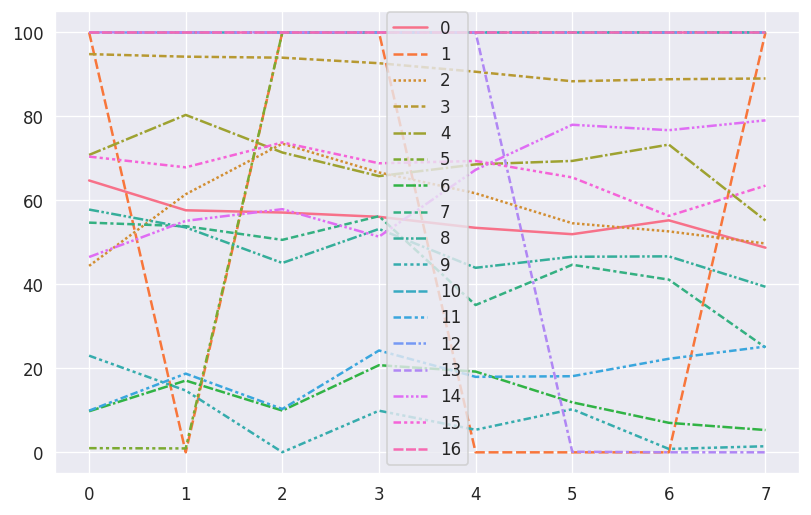

In [76]:
metrics_evo_tree = metrics_evo["F1"].apply(pd.Series)

# metrics_evo_tree.columns += 1
# metrics_evo_tree = metrics_evo_tree.melt()

# metrics_evo_tree.columns = ["tree_type", "f1-score"]

sns.lineplot(
    metrics_evo_tree
)

metrics_evo_tree.style.background_gradient()

# Análise qualitativa das imagens

In [90]:
if "orthoimage" not in globals():
    orthoimage = read_tiff(args.ortho_image)

orthoimage_ = np.moveaxis(orthoimage, 0,2).copy()

In [81]:
last_iter_folder = iter_folders[-1]

label_img = read_tiff(os.path.join(DATA_PATH, last_iter_folder, "new_labels", "selected_labels_set.tif"))
# label_img = read_tiff(os.path.join(DATA_PATH, args['train_segmentation_path']))

components = label(label_img)

components_id = np.unique(components)

components_id = components_id[np.nonzero(components_id)]

num_components = 9
components_selected = np.random.choice(components_id,  num_components)

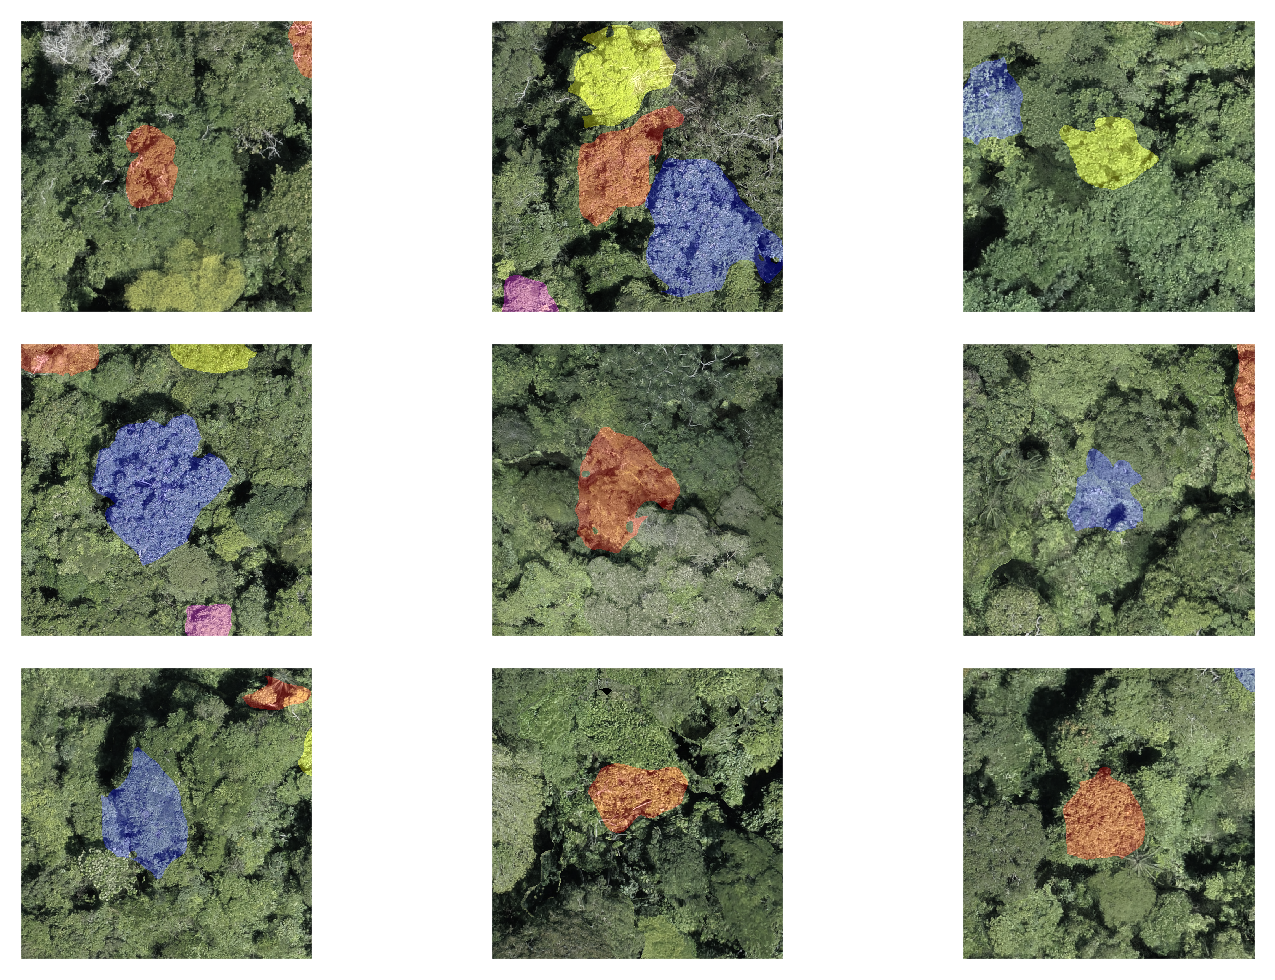

In [84]:
col_wrap = 3

nrows = int(np.ceil(num_components/col_wrap))

fig, ax = plt.subplots(nrows=nrows, ncols=col_wrap, sharex=False, sharey=False)

fig.set_dpi(200)

for num, comp_id in enumerate(components_selected):
    coords = np.argwhere(components==comp_id)

    down, top = coords[:, 0].max(),  coords[:, 0].min()

    right, left = coords[:, 1].max(),  coords[:, 1].min()

    # adding margin
    margin = 256
    down += margin
    top -= margin

    right += margin
    left -= margin

    #### create a square ###
    if np.abs(top-down) > np.abs(right - left):
        right = left+np.abs(top-down)
    
    if np.abs(top-down) < np.abs(right - left):
        down = top+np.abs(right - left)
    
    image = orthoimage_[top:down, left:right].copy()
    # image = image/image.max()
    image = (image - image.min()) / (np.quantile(image, 0.99) - image.min())
    
    img_with_label = label2rgb(label_img[top:down, left:right], image, saturation=.5)
    # mask = np.where(label_img[top:down, left:right] > 0, 1, 0)*0.3

    # image[:,:, 0] += mask
    # image[:,:, 1] += mask
    # image[:,:, 2] += mask


    ax.flat[num].imshow(img_with_label, interpolation='nearest')
    
    ax.flat[num].set_xticks([])
    ax.flat[num].set_yticks([])

    ax.flat[num].set_xticklabels([])
    ax.flat[num].set_yticklabels([])
    


fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

# Exportando Relatório

In [105]:
report_output_path = join(DATA_PATH)

In [107]:
import subprocess

# Example of running 'ls -l' and capturing output
result = subprocess.run(
["jupyter", "nbconvert", "--to", "html",
"generate_results.ipynb", f"--output-dir={report_output_path}"], capture_output=True, text=True)


print(result.stdout)
